# Все действия были проделаны в google colaboratory на бесплатном GPU
  
<b> Скачивание файлов с google drive из папки DMIA лежащей в корневой папке, их перемещение и установка gensim
  https://contest.yandex.ru/algorithm2018/contest/7914/download/1/ - dataset
  http://rusvectores.org/static/models/rusvectores4/fasttext/araneum_none_fasttextskipgram_300_5_2018.tgz - fasttext
  

In [1]:
from google.colab import auth
from googleapiclient.discovery import build
import io , requests, os
import sys
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

def get_parent_folder(folder_name):
  page_token = None
  folder_array = []
  query = "name='%s' and mimeType='application/vnd.google-apps.folder'" % folder_name
  while True:
      response = drive_service.files().list(q=query,
                                          spaces='drive',
                                          fields='nextPageToken,files(id, name)',
                                          pageToken=page_token).execute()
      for file in response.get('files', []):
          # Process change
          #print (file.get('name'), file.get('id'))
          folder_array.append({"name" : file.get('name'), "id" : file.get('id')})
      page_token = response.get('nextPageToken', None)
      if page_token is None:
          break
  return folder_array

def get_files_from_parent(parent_id):
  page_token = None
  folder_array = dict()
  query = "'%s' in parents" % parent_id
  while True:
      response = drive_service.files().list(q=query,
                                          spaces='drive',
                                          fields='nextPageToken, files(id, name)',
                                          pageToken=page_token).execute()
      for file in response.get('files', []):
          # Process change
          #print (file.get('name'), file.get('id'))
          folder_array.update({file.get('name'):file.get('id')})
      page_token = response.get('nextPageToken', None)
      if page_token is None:
          break
  return folder_array

def get_file_buffer(file_id, verbose=0):
  from googleapiclient.http import MediaIoBaseDownload
  request = drive_service.files().get_media(fileId=file_id)
  downloaded = io.BytesIO()
  downloader = MediaIoBaseDownload(downloaded, request)
  done = False
  while done is False:
    # _ is a placeholder for a progress object that we ignore.
    # (Our file is small, so we skip reporting progress.)
    progress, done = downloader.next_chunk()
    if verbose:
      sys.stdout.flush()
      sys.stdout.write('\r')
      percentage_done = progress.resumable_progress * 100/progress.total_size
      sys.stdout.write("[%-100s] %d%%" % ('='*int(percentage_done), int(percentage_done)))
  downloaded.seek(0)
  return downloaded

parent_folder = get_parent_folder('DMIA')
print(parent_folder)
parent_folder[0]["id"]
input_file_meta = get_files_from_parent(parent_folder[0]["id"])
print(input_file_meta)
for file, id in input_file_meta.items():
  downloaded = get_file_buffer(id, verbose=1)
  dest_file = os.path.join('.', file)
  print("processing %s data" % file)
  with open(dest_file, "wb") as out:
    out.write(downloaded.read())
    print("Done %s" % dest_file)

!mkdir data
!mv araneum_none_fasttextskipgram_300_5_2018.model data/araneum_none_fasttextskipgram_300_5_2018.model
!mv train.tsv data/train.tsv
!mv public.tsv data/public.tsv
!mv araneum_none_fasttextskipgram_300_5_2018.model.syn0_vocab_lockf.npy data/araneum_none_fasttextskipgram_300_5_2018.model.syn0_vocab_lockf.npy
!mv araneum_none_fasttextskipgram_300_5_2018.model.syn1neg.npy data/araneum_none_fasttextskipgram_300_5_2018.model.syn1neg.npy
!mv araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0.npy data/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0.npy
!mv araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy data/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy

!pip install gensim

[{'name': 'DMIA', 'id': '15UrzrRpWV_fuEf9C8cbif91gVuq7yYvr'}]
{'araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy': '13Zx0oqgjM2uqOrWCqh6-_YYQaNX-DpPk', 'araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0.npy': '16oYYCdaUY53_pPADpUP21wBJvTBtaGuA', 'araneum_none_fasttextskipgram_300_5_2018.model.syn1neg.npy': '1r2fnosTTq1E_Zgyv5qCmnELzc1Ap6Sas', 'araneum_none_fasttextskipgram_300_5_2018.model.syn0_vocab_lockf.npy': '11zApSJGVVLsdN6-CbAi9C1OL1iQ1zcAd', 'train.tsv': '1t1R_y_IFpqC5m983uZZDZ72odojDSS59', 'public.tsv': '1QECZAkzg0CbwP9ohozYHEbqADHsEWqEc', 'araneum_none_fasttextskipgram_300_5_2018.model': '1BsjkFdTcJGTOJU-fVYapfXKRMc5jcoa7'}
[====================================================================================================] 100%processing araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy data
Done ./araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy
[=============================================================================

    100% |████████████████████████████████| 1.4MB 938kB/s 
    100% |████████████████████████████████| 133kB 7.6MB/s 
    100% |████████████████████████████████| 4.2MB 326kB/s 
    100% |████████████████████████████████| 61kB 9.1MB/s 
    100% |████████████████████████████████| 552kB 2.1MB/s 
  Running setup.py bdist_wheel for smart-open ... - done
  Stored in directory: /content/.cache/pip/wheels/b1/9e/7d/bb3d3b55c597e72617140a0638c06382a5f17283881eae163e
  Running setup.py bdist_wheel for bz2file ... - done
  Stored in directory: /content/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
Successfully built smart-open bz2file
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


<b> Описание данных и задачи </b>

Каждый эпизод состоит из двух частей – контекста (Context) и финальной реплики (Reply). Например,

- context_2: Персонаж A говорит реплику 
- context_1: Персонаж B отвечает на нее 
- context_0: Персонаж А произносит вторую реплику 
- reply: Персонаж B отвечает на вторую реплику 

Контекстная часть может состоять из трех реплик (как в примере) – в 50% случаев, двух – в 25%, и одного – в оставшихся 25% случаев. Финальная реплика (Reply) всегда завершает любой эпизод, то есть следует за контекстом (Context). Задача участников – найти наиболее подходящую и интересную реплику для данного контекста среди предложенных кандидатов (числом до 6), случайно выбранных из топа кандидатов, возвращенных бейзлайном высокого качества, натренированным командой Алисы (который, в свою очередь, отобрал кандидатов среди всех возможных реплик OpenSubtitles).

Все реплики-кандидаты размечены асессорами на сервисе Яндекс.Толока с помощью следующей инструкции для разметки:

- Good (2): реплика уместна (имеет смысл для данного контекста) и интересна (нетривиальна, специфична именно для данного контекста, мотивирует продолжать разговор)
- Neutral (1): реплика уместна (имеет смысл для данного контекста), но не интересна (тривиальна, не специфична для данного контекста и скорее подталкивает пользователя закончить разговор)
- Bad (0): реплика не имеет никакого смысла в данном контексте

Каждая метка в тренировочной части датасета (и только в ней), сопровождается также уверенностью (confidence) – числом в интервале от 0 до 1 – которое показывает насколько уверенными в своей разметке были асессоры с Толоки, совместно предложившие данную метку. Мы хотим обратить особое внимание участников на эту информацию, она может быть очень полезна при обучении их моделей.

- context_id – идентификатор эпизода
- context_2,context_1,context_0 – текст реплик, предшествующих финальной (может состоять из трех частей)
- reply_id – идентификатор реплики-кандидата
- reply – текст реплики-кандидата
- label – метка реплики-кандидата (good, neutral или bad)
- confidence - уверенность в метке реплики-кандидата (число от 0 до 1)

In [2]:
import pandas as pd
import numpy as np

from keras.models import Sequential, Model
from keras.layers import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers

import matplotlib.pyplot as plt
import seaborn as sns
import gensim
ft = gensim.models.FastText.load('data/araneum_none_fasttextskipgram_300_5_2018.model')

import re

from sklearn.metrics import make_scorer, accuracy_score
%matplotlib inline

Using TensorFlow backend.


<b> Метрика для оценки качества. Выбрана исходя из задачи ранжирования.

In [0]:
def DCG(label): return sum([float(label[i]/np.log2(i+2)) for i in range(len(label))])

def nDCG(label, best_label):
    label, best_label = DCG(label), DCG(best_label)
    if label != 0 and best_label != 0:
        return label/best_label
    else:
        return 0

<b> Загружаем данные, конкатенируем трейн и тест

In [0]:
df_train = pd.read_csv("data/train.tsv", sep='\t', quotechar=' ', header = None)
df_train.columns = ['context_id', 'context_2', 'context_1', 'context_0', 'reply_id', 'reply', 'label', 'confidence']

df_public = pd.read_csv("data/public.tsv", sep='\t', quotechar=' ', header = None)
df_public.columns = ['context_id', 'context_2', 'context_1', 'context_0', 'reply_id', 'reply']

df_data = pd.concat((df_train, df_public)).reset_index(drop=True)

<b>Заменяем лейблы и заполняем пустые значения confidence на 1 (Почему так рассмотрим далее), остальные на -, меняем порядок столбцов

In [0]:
df_data.label = df_data.label.map({'good': 2, 'neutral': 1, 'bad': 0})
df_data.confidence.fillna(value=1, inplace=True)
df_data.fillna(value='-', inplace=True)
df_data = df_data[['context_id', 'context_2', 'context_1', 'context_0', 'reply_id', 'reply', 'label', 'confidence']]

<b> Выделяем из общего датафрейма трейн и тест (для удобства дальнейшей визуализации)

In [6]:
train_tres = len(df_train)
df_train = df_data.loc[:train_tres-1]
df_public = df_data.loc[train_tres:]

df_train.confidence = df_train.confidence.astype(float)
df_train.label = df_train.label.astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


# Часть визуализации

<b> Смотрим на распределения confidence и лейблов по трейну

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


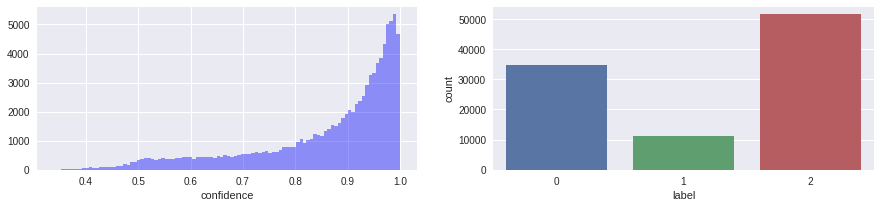

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,3))
sns.distplot(df_train['confidence'], bins=100, kde=False, ax=ax[0], color=['b'])
sns.countplot(x='label', data=df_train, ax=ax[1]);

<b> Смотрим на распределения кол-ва слов в context и reply в трейн и тесте (слова выделялись пробелами)

CPU times: user 1.28 s, sys: 3 ms, total: 1.28 s
Wall time: 1.28 s


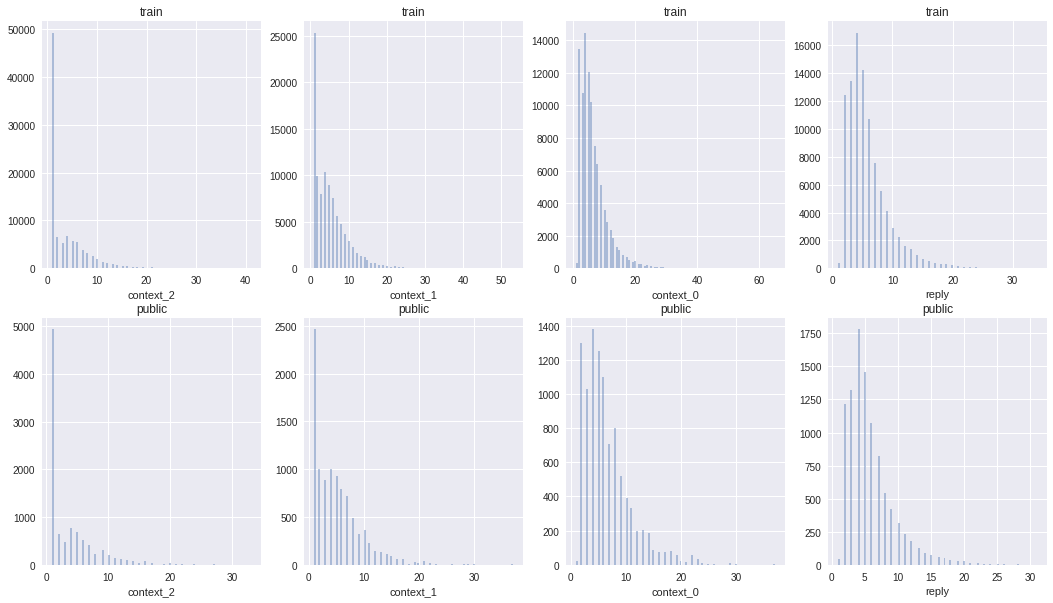

In [8]:
%%time
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(18,10))

for i in range(3):
    sns.distplot(df_train[f'context_{2-i}'].apply(lambda x: len(str(x).split(' '))), bins=100, kde=False, ax=ax[0,i])
    ax[0,i].set_title('train')
sns.distplot(df_train['reply'].apply(lambda x: len(str(x).split(' '))), bins=100, kde=False, ax=ax[0,i+1])
ax[0,i+1].set_title('train')

for i in range(3):
    sns.distplot(df_public[f'context_{2-i}'].apply(lambda x: len(str(x).split(' '))), bins=100, kde=False, ax=ax[1,i])
    ax[1,i].set_title('public')
sns.distplot(df_public['reply'].apply(lambda x: len(str(x).split(' '))), bins=100, kde=False, ax=ax[1,i+1])
ax[1,i+1].set_title('public')

<b>Как видно из картинок в тесте и трейне кол-ва слов распределены примерно одинаково

<b>Далее смотрим на длину всего диалога в тесте и трейне

CPU times: user 10.9 s, sys: 0 ns, total: 10.9 s
Wall time: 10.9 s


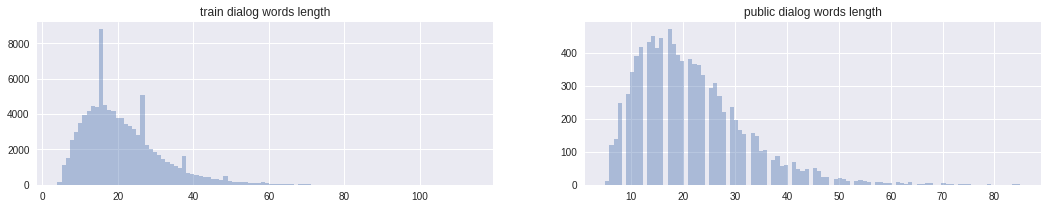

In [9]:
%%time
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,3))

sns.distplot(df_train[['context_2', 'context_1', 'context_0', 'reply']].apply(lambda x : 
                                                                              len((" ".join(x.astype(str))).split(' ')), 
                                                                              axis = 1),
            bins=100, kde=False, ax=ax[0])
ax[0].set_title('train dialog words length')

sns.distplot(df_public[['context_2', 'context_1', 'context_0', 'reply']].apply(lambda x : 
                                                                              len((" ".join(x.astype(str))).split(' ')), 
                                                                              axis = 1),
            bins=100, kde=False, ax=ax[1])
ax[1].set_title('public dialog words length')

<b>Как и ожидалось распределения одинаковы

<b>Теперь подсчитываем из скольки контекстов состоит диалог и смотрим распределения

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


CPU times: user 30.2 s, sys: 668 ms, total: 30.9 s
Wall time: 30.9 s


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


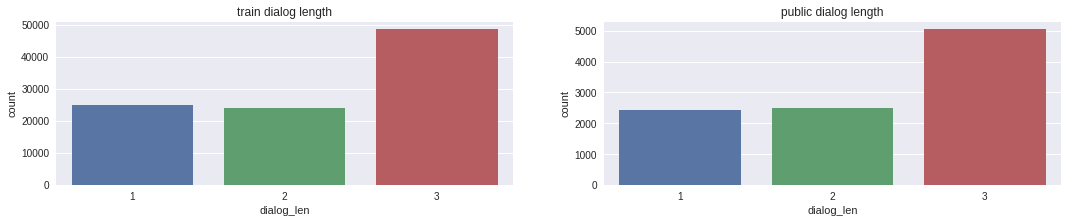

In [10]:
%%time
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,3))

df_train['dialog_len'] = df_train[['context_2', 'context_1', 'context_0']].apply(lambda x: 3-sum(x=='-'), axis=1)
sns.countplot(x='dialog_len', data=df_train, ax=ax[0]);
ax[0].set_title('train dialog length')

df_public['dialog_len'] = df_public[['context_2', 'context_1', 'context_0']].apply(lambda x: 3-sum(x=='-'), axis=1)
sns.countplot(x='dialog_len', data=df_public, ax=ax[1]);
ax[1].set_title('public dialog length')

<b>Опять таки мы видим, что распределения в трейне и тесте одинаковы

<b>Далее проверяем граничные значения (Например, одно слово в context или reply), а именно: 
- распределение confidence и лейблов для длины диалога = 1
- распределение confidence и лейблов для длины reply = 1
- распределение confidence и лейблов для длины reply = 2
- распределение confidence и лейблов для длины reply >= 2
- распределение confidence и лейблов для длины reply = 1 и длины диалога = 1

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


CPU times: user 1.45 s, sys: 18 ms, total: 1.47 s
Wall time: 1.47 s


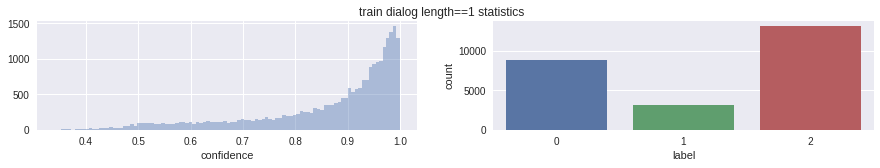

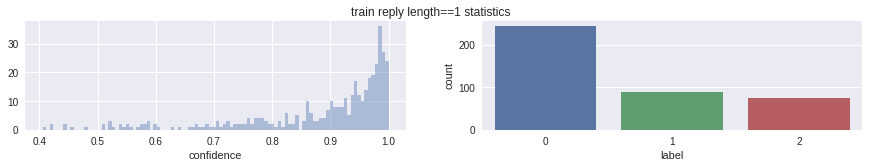

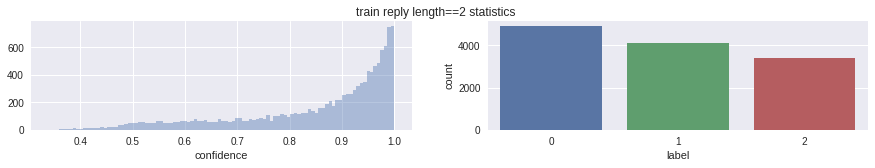

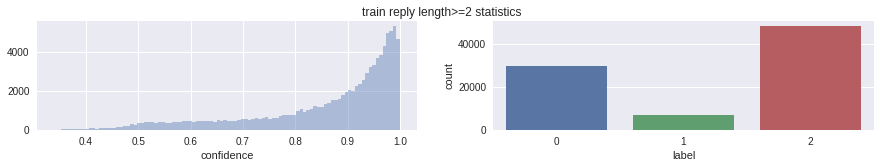

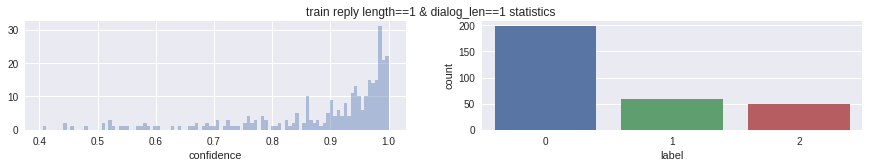

In [11]:
%%time
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,2))
sns.distplot(df_train[df_train['dialog_len'] == 1].confidence, bins=100, kde=False, ax=ax[0])
sns.countplot(x='label', data=df_train[df_train['dialog_len'] == 1], ax=ax[1])
fig.suptitle('train dialog length==1 statistics')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,2))
sns.distplot(df_train[df_train.reply.apply(lambda x: len(x.split()) == 1)].confidence, bins=100, kde=False, ax=ax[0])
sns.countplot(x='label', data=df_train[df_train.reply.apply(lambda x: len(x.split()) == 1)], ax=ax[1])
fig.suptitle('train reply length==1 statistics')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,2))
sns.distplot(df_train[df_train.reply.apply(lambda x: len(x.split()) == 2)].confidence, bins=100, kde=False, ax=ax[0])
sns.countplot(x='label', data=df_train[df_train.reply.apply(lambda x: len(x.split()) == 2)], ax=ax[1])
fig.suptitle('train reply length==2 statistics')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,2))
sns.distplot(df_train[df_train.reply.apply(lambda x: len(x.split()) >= 2)].confidence, bins=100, kde=False, ax=ax[0])
sns.countplot(x='label', data=df_train[df_train.reply.apply(lambda x: len(x.split()) > 2)], ax=ax[1])
fig.suptitle('train reply length>=2 statistics')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (15,2))
sns.distplot(df_train[df_train.reply.apply(lambda x: len(x.split()) == 1) & (df_train['dialog_len'] == 1)].confidence, bins=100, kde=False, ax=ax[0])
sns.countplot(x='label', data=df_train[df_train.reply.apply(lambda x: len(x.split()) == 1) & (df_train['dialog_len'] == 1)], ax=ax[1])
fig.suptitle('train reply length==1 & dialog_len==1 statistics')

<b>Как мы видим при длине диалога 1 и длине reply 1 у нас почти в большинстве случаев лейбл 0

<b>Дальше попытаемся как-то использовать confidence. В данном случае confidence для других лейблов считался как (1-confidence)/2 и для этой формулы confidence для тестовой части мы взяли как 1. В этом случае confidence для лейблов для тестовой части будет 0. Можно было избежать мороки с confidence для тестовой части 1 просто сделав срез для трейн части, но суть от этого не изменится. <br>

В итоге мы расширили фичу confidence и будем их использовать как лейбл

In [12]:
%%time
df_data['inv_confidence_div2'] = (1 - df_data.confidence)/2

df_data['label0_confidence'] = 0
df_data['label1_confidence'] = 0
df_data['label2_confidence'] = 0

df_data['label0_confidence'] = df_data[['label0_confidence', 'label', 'inv_confidence_div2', 'confidence']].apply(lambda x: x.confidence if x.label==0 else x.inv_confidence_div2 ,axis=1)
df_data['label1_confidence'] = df_data[['label1_confidence', 'label', 'inv_confidence_div2', 'confidence']].apply(lambda x: x.confidence if x.label==1 else x.inv_confidence_div2 ,axis=1)
df_data['label2_confidence'] = df_data[['label2_confidence', 'label', 'inv_confidence_div2', 'confidence']].apply(lambda x: x.confidence if x.label==2 else x.inv_confidence_div2 ,axis=1)

CPU times: user 10 s, sys: 4 ms, total: 10 s
Wall time: 10 s


<b>Теперь нужно избавиться от всех символов кроме русских (в датасете могут присутствовать не русские символы и на самом деле так и есть) , так как наш эмбеддинг над словами будет из fasttext. Сделаем это с помощью регулярных выражений

In [13]:
%%time
reg = re.compile('[^а-яА-Я]')
df_data['context_2'] = df_data['context_2'].apply(lambda x: reg.sub(r' ', x))
df_data['context_1'] = df_data['context_1'].apply(lambda x: reg.sub(r' ', x))
df_data['context_0'] = df_data['context_0'].apply(lambda x: reg.sub(r' ', x))
df_data['reply'] = df_data['reply'].apply(lambda x: reg.sub(r' ', x))

CPU times: user 738 ms, sys: 0 ns, total: 738 ms
Wall time: 741 ms


<b>Теперь возьмем слова с длиной 3 символа и более (потому что наш эмбеддинг обучался на 3-5 грамах) и обрежем наши context и reply. Для того, чтобы понять на сколько обрезать нужно смотреть на наши графики с распределением кол-ва слов. В итоге имеем: context2 - 10 слов, context1 - 15 слов, context0 - 20 слов, reply - 15 слов.

In [14]:
%%time
temp = df_data['context_2'].apply(lambda x: x.split(' '))
df_data['context_2_cutted'] = temp.apply( lambda x: list(filter(lambda y : len(y) >= 3, x))[:10] )

temp = df_data['context_1'].apply(lambda x: x.split(' '))
df_data['context_1_cutted'] = temp.apply(lambda x: list(filter(lambda y : len(y) >= 3, x))[:15] )

temp = df_data['context_0'].apply(lambda x: x.split(' '))
df_data['context_0_cutted'] = temp.apply(lambda x: list(filter(lambda y : len(y) >= 3, x))[:20] )

temp = df_data['reply'].apply(lambda x: x.split(' '))
df_data['reply_cutted'] = temp.apply(lambda x: list(filter(lambda y : len(y) >= 3, x))[:15] )

CPU times: user 2.29 s, sys: 125 ms, total: 2.41 s
Wall time: 2.42 s


<b>Найдем и удалим из данных строки, где после наших махинаций длина reply или context0 равны 0

In [15]:
%%time
data_zero_reply_loc = df_data['reply_cutted'][df_data['reply_cutted'].apply(lambda x: len(x)==0)].index.values
data_zero_context_0_loc = df_data['context_0_cutted'][df_data['context_0_cutted'].apply(lambda x: len(x)==0)].index.values

data_noise = list(set(data_zero_reply_loc) | set(data_zero_context_0_loc))
df_data_cleared = df_data.drop(labels=data_noise)
print(len(data_noise))

4591
CPU times: user 117 ms, sys: 8 ms, total: 125 ms
Wall time: 128 ms


In [16]:
df_data_cleared.sample()

,context_id,context_2,context_1,context_0,reply_id,reply,label,confidence,inv_confidence_div2,label0_confidence,label1_confidence,label2_confidence,context_2_cutted,context_1_cutted,context_0_cutted,reply_cutted
70168,201928924404900,неприятная ситуация была побочным результатом ...,все равно лучше быть на твоем месте,будь что будет,3,все будет хорошо,2,0.877832,0.061084,0.061084,0.061084,0.877832,"[неприятная, ситуация, была, побочным, результ...","[все, равно, лучше, быть, твоем, месте]","[будь, что, будет]","[все, будет, хорошо]"


# Часть кросс валидации
<b>Теперь разберемся с кроссвалидацией и моделью. <br>
Модель выбрана нейросетевая (хотя она тут не очень подходит, так как данных для нейронной сети (глубокой) очень мало, порядка 70 тыс.) <br>
Валидационная выборка это будут последние 20% теста. Данный тип валидации подходит, так как здесь нет временной зависимости или какой-либо еще не тривиальной.

Модель: 2 входа context и reply, далее embedding на fasttext, CNN для context и для reply. Потом идет конкатенация двух CNN, потом Dense слой и слой softmax. loss - categorical_crossentropy, оптимизатор - AMSgrad.

In [0]:
df_train = df_data_cleared.loc[:train_tres]
CV_COEF = 0.8
cv_train_tres = int(len(df_train) * CV_COEF)
cv_train_y = df_train[['label0_confidence', 'label1_confidence', 'label2_confidence']][:cv_train_tres].values
cv_val_y = df_train[['label0_confidence', 'label1_confidence', 'label2_confidence']][cv_train_tres:].values

<b>Создадим данные для входа в нейросеть (конатенация диалога без reply)

In [0]:
cv_train_context = df_train['context_2_cutted'] + df_train['context_1_cutted'] + df_train['context_0_cutted']
cv_train_reply = df_train['reply_cutted']

<b>Определим максимальную длину диалога для каждого входа, размер эмбеддинга (задается самой моделью fasttext-а) и кол-во токенов

In [0]:
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH_CONTEXT = 45
MAX_SEQUENCE_LENGTH_REPLY = 15
EMBEDDING_DIM = 300

<b>Создадим токены, приведем входные данные к одной длине и разобьем данные на трейн и валидацию

In [21]:
%%time

tokenizer_context = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer_context.fit_on_texts(cv_train_context)
sequences_context = tokenizer_context.texts_to_sequences(cv_train_context)
word_index_context = tokenizer_context.word_index
data_context = pad_sequences(sequences_context, maxlen=MAX_SEQUENCE_LENGTH_CONTEXT)

X_train_context = data_context[:cv_train_tres]
X_val_context = data_context[cv_train_tres:]

#################################################################################

tokenizer_reply = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer_reply.fit_on_texts(cv_train_reply)
sequences_reply = tokenizer_reply.texts_to_sequences(cv_train_reply)
word_index_reply = tokenizer_reply.word_index
data_reply = pad_sequences(sequences_reply, maxlen=MAX_SEQUENCE_LENGTH_REPLY)

X_train_reply = data_reply[:cv_train_tres]
X_val_reply = data_reply[cv_train_tres:]

CPU times: user 2.32 s, sys: 22 ms, total: 2.34 s
Wall time: 2.35 s


<b>Создадим эмбеддинги для слов

In [22]:
%%time

input_context = Input(shape=(MAX_SEQUENCE_LENGTH_CONTEXT, ))
embedding_matrix_context = np.zeros((len(word_index_context) + 1, EMBEDDING_DIM))
for word, i in word_index_context.items():
    embedding_vector = ft.wv[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_context[i] = embedding_vector
word_embed_context = Embedding(len(word_index_context) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_context],
                            input_length=MAX_SEQUENCE_LENGTH_CONTEXT,
                            trainable=False)(input_context)

##############################################################################

input_reply = Input(shape=(MAX_SEQUENCE_LENGTH_REPLY, ))
embedding_matrix_reply = np.zeros((len(word_index_reply) + 1, EMBEDDING_DIM))
for word, i in word_index_reply.items():
    embedding_vector = ft.wv[word]
    if embedding_vector is not None:
        embedding_matrix_reply[i] = embedding_vector
word_embed_reply = Embedding(len(word_index_reply) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_reply],
                            input_length=MAX_SEQUENCE_LENGTH_REPLY,
                            trainable=False)(input_reply)

CPU times: user 2.01 s, sys: 265 ms, total: 2.28 s
Wall time: 2.29 s


<b>Определим модель и начнем обучение на 10 эпохах с батчем в 64. <br>
  Парамерты и архитектура модели подбирались на основе валидации путем проб и ошибок.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 45, 300)      7153500     input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_126 (Conv1D)             (None, 45, 16)       24016       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
max_poolin

74658/74658 [==============================] - 25s 331us/step - loss: 1.0150 - acc: 0.4998 - val_loss: 0.9632 - val_acc: 0.5460
Epoch 2/10
62208/74658 [=======================>......] - ETA: 3s - loss: 0.9711 - acc: 0.5363

74658/74658 [==============================] - 22s 295us/step - loss: 0.9691 - acc: 0.5384 - val_loss: 0.9527 - val_acc: 0.5598
Epoch 3/10
74658/74658 [==============================] - 22s 294us/step - loss: 0.9563 - acc: 0.5561 - val_loss: 0.9537 - val_acc: 0.5532
Epoch 4/10
 5312/74658 [=>............................] - ETA: 19s - loss: 0.9493 - acc: 0.5689

74658/74658 [==============================] - 22s 294us/step - loss: 0.9480 - acc: 0.5669 - val_loss: 0.9433 - val_acc: 0.5702
Epoch 5/10
62208/74658 [=======================>......] - ETA: 3s - loss: 0.9426 - acc: 0.5746

74658/74658 [==============================] - 22s 295us/step - loss: 0.9426 - acc: 0.5743 - val_loss: 0.9405 - val_acc: 0.5739
Epoch 6/10
74658/74658 [==============================] - 22s 297us/step - loss: 0.9373 - acc: 0.5797 - val_loss: 0.9393 - val_acc: 0.5736
Epoch 7/10
 5440/74658 [=>............................] - ETA: 19s - loss: 0.9327 - acc: 0.5847

74658/74658 [==============================] - 22s 295us/step - loss: 0.9329 - acc: 0.5859 - val_loss: 0.9387 - val_acc: 0.5731
Epoch 8/10
62144/74658 [=======================>......] - ETA: 3s - loss: 0.9281 - acc: 0.5908

74658/74658 [==============================] - 22s 297us/step - loss: 0.9279 - acc: 0.5911 - val_loss: 0.9422 - val_acc: 0.5758
Epoch 9/10
74658/74658 [==============================] - 22s 293us/step - loss: 0.9230 - acc: 0.5968 - val_loss: 0.9410 - val_acc: 0.5636
Epoch 10/10
 5824/74658 [=>............................] - ETA: 19s - loss: 0.9149 - acc: 0.6011

74658/74658 [==============================] - 22s 293us/step - loss: 0.9179 - acc: 0.6025 - val_loss: 0.9415 - val_acc: 0.5755


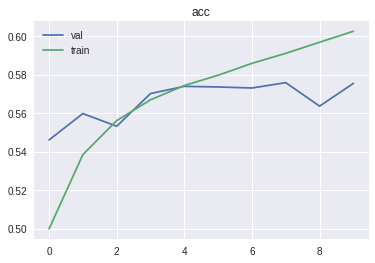

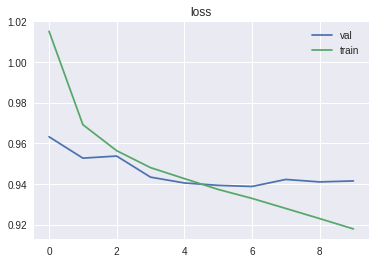

In [56]:
BATCH_SIZE = 64

context_conv1 = Conv1D(16, 5, padding='same')(word_embed_context)
context_max_pool1 = MaxPooling1D(pool_size=2)(context_conv1)
context_conv2 = Conv1D(32, 3, padding='same')(context_max_pool1)
context_max_pool2 = MaxPooling1D(pool_size=2)(context_conv2)
context_conv3 = Conv1D(64, 3, padding='same')(context_max_pool2)
context_max_pool3 = MaxPooling1D(pool_size=2)(context_conv3)
context_flatten = Flatten()(context_max_pool3)

reply_conv1 = Conv1D(32, 5, padding='same')(word_embed_reply)
reply_max_pool1 = MaxPooling1D(pool_size=2)(reply_conv1)
reply_conv2 = Conv1D(64, 3, padding='same')(reply_max_pool1)
reply_max_pool2 = MaxPooling1D(pool_size=2)(reply_conv2)
reply_flatten = Flatten()(reply_max_pool2)

merged = concatenate([context_flatten, reply_flatten])
drop_0 = Dropout(0.3)(merged)
dense_0 = Dense(256, activation='sigmoid')(drop_0)
drop_1 = Dropout(0.3)(dense_0)
dense_out = Dense(3, activation='softmax')(drop_1)

model = Model(inputs=[input_context, input_reply], outputs=[dense_out])
model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

hist = model.fit([X_train_context, X_train_reply], cv_train_y, batch_size=BATCH_SIZE, epochs=10, validation_data=([X_val_context, X_val_reply], cv_val_y))
plt.figure()
plt.title('acc')
plt.plot(hist.history['val_acc'], label='val')
plt.plot(hist.history['acc'], label='train')
plt.legend()
plt.figure()
plt.title('loss')
plt.plot(hist.history['val_loss'], label='val')
plt.plot(hist.history['loss'], label='train')
plt.legend()

<b> Теперь обучим модель на 6 эпохах (выбор был сделан исходя из графика лосса на валидации - минимальная точка на графике)

In [57]:
context_conv1 = Conv1D(16, 5, padding='same')(word_embed_context)
context_max_pool1 = MaxPooling1D(pool_size=2)(context_conv1)
context_conv2 = Conv1D(32, 3, padding='same')(context_max_pool1)
context_max_pool2 = MaxPooling1D(pool_size=2)(context_conv2)
context_conv3 = Conv1D(64, 3, padding='same')(context_max_pool2)
context_max_pool3 = MaxPooling1D(pool_size=2)(context_conv3)
context_flatten = Flatten()(context_max_pool3)

reply_conv1 = Conv1D(32, 5, padding='same')(word_embed_reply)
reply_max_pool1 = MaxPooling1D(pool_size=2)(reply_conv1)
reply_conv2 = Conv1D(64, 3, padding='same')(reply_max_pool1)
reply_max_pool2 = MaxPooling1D(pool_size=2)(reply_conv2)
reply_flatten = Flatten()(reply_max_pool2)

merged = concatenate([context_flatten, reply_flatten])
drop_0 = Dropout(0.3)(merged)
dense_0 = Dense(256, activation='sigmoid')(drop_0)
drop_1 = Dropout(0.3)(dense_0)
dense_out = Dense(3, activation='softmax')(drop_1)

model = Model(inputs=[input_context, input_reply], outputs=[dense_out])
model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit([X_train_context, X_train_reply], cv_train_y, batch_size=BATCH_SIZE, epochs=6, validation_data=([X_val_context, X_val_reply], cv_val_y))

Train on 74658 samples, validate on 18665 samples
Epoch 1/6
74658/74658 [==============================] - 25s 335us/step - loss: 1.0283 - acc: 0.4873 - val_loss: 0.9655 - val_acc: 0.5430
Epoch 2/6
32512/74658 [============>.................] - ETA: 11s - loss: 0.9795 - acc: 0.5289

74658/74658 [==============================] - 22s 293us/step - loss: 0.9715 - acc: 0.5378 - val_loss: 0.9534 - val_acc: 0.5593
Epoch 3/6
73856/74658 [============================>.] - ETA: 0s - loss: 0.9577 - acc: 0.5581

74658/74658 [==============================] - 22s 293us/step - loss: 0.9577 - acc: 0.5580 - val_loss: 0.9473 - val_acc: 0.5632
Epoch 4/6
74658/74658 [==============================] - 22s 294us/step - loss: 0.9498 - acc: 0.5655 - val_loss: 0.9426 - val_acc: 0.5676
Epoch 5/6
 8128/74658 [==>...........................] - ETA: 18s - loss: 0.9462 - acc: 0.5709

74658/74658 [==============================] - 22s 294us/step - loss: 0.9434 - acc: 0.5714 - val_loss: 0.9397 - val_acc: 0.5722
Epoch 6/6
63744/74658 [========================>.....] - ETA: 3s - loss: 0.9401 - acc: 0.5767

74658/74658 [==============================] - 22s 296us/step - loss: 0.9388 - acc: 0.5777 - val_loss: 0.9383 - val_acc: 0.5755


<b> Делаем предикт для валидационной выборке и считаем скор

In [61]:
y_pred = model.predict([X_val_context, X_val_reply])
y_pred_classes = np.argmax(y_pred, axis=1)
cv_val_classes = np.argmax(cv_val_y, axis=1)
nDCG(cv_val_classes, y_pred_classes)

0.7446212469964736

# Часть обучения


<b> Отделим тест и трейн

In [62]:
%%time
train_inds = df_data[df_data.label != '-'].index.values
test_inds = df_data[df_data.label == '-'].index.values
y_train = df_data[df_data.label != '-'][['label0_confidence', 'label1_confidence', 'label2_confidence']].values

context = df_data['context_2_cutted'] + df_data['context_1_cutted'] + df_data['context_0_cutted']
reply = df_data['reply_cutted']

CPU times: user 892 ms, sys: 28 ms, total: 920 ms
Wall time: 908 ms


<b>Сделаем те же процедуры для эмбединга, какие делали для кроссвалидации 


In [63]:
%%time

tokenizer_context = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer_context.fit_on_texts(context)
sequences_context = tokenizer_context.texts_to_sequences(context)
word_index_context = tokenizer_context.word_index
data_context = pad_sequences(sequences_context, maxlen=MAX_SEQUENCE_LENGTH_CONTEXT)

train_context = data_context[train_inds]
test_context = data_context[test_inds]

#################################################################################

tokenizer_reply = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer_reply.fit_on_texts(reply)
sequences_reply = tokenizer_reply.texts_to_sequences(reply)
word_index_reply = tokenizer_reply.word_index
data_reply = pad_sequences(sequences_reply, maxlen=MAX_SEQUENCE_LENGTH_REPLY)

train_reply = data_reply[train_inds]
test_reply = data_reply[test_inds]

CPU times: user 2.6 s, sys: 45 ms, total: 2.65 s
Wall time: 2.63 s


In [64]:
%%time

input_context = Input(shape=(MAX_SEQUENCE_LENGTH_CONTEXT, ))
embedding_matrix_context = np.zeros((len(word_index_context) + 1, EMBEDDING_DIM))
for word, i in word_index_context.items():
    embedding_vector = ft.wv[word]
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_context[i] = embedding_vector
word_embed_context = Embedding(len(word_index_context) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_context],
                            input_length=MAX_SEQUENCE_LENGTH_CONTEXT,
                            trainable=False)(input_context)

##############################################################################

input_reply = Input(shape=(MAX_SEQUENCE_LENGTH_REPLY, ))
embedding_matrix_reply = np.zeros((len(word_index_reply) + 1, EMBEDDING_DIM))
for word, i in word_index_reply.items():
    embedding_vector = ft.wv[word]
    if embedding_vector is not None:
        embedding_matrix_reply[i] = embedding_vector
word_embed_reply = Embedding(len(word_index_reply) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix_reply],
                            input_length=MAX_SEQUENCE_LENGTH_REPLY,
                            trainable=False)(input_reply)

CPU times: user 8.77 s, sys: 182 ms, total: 8.95 s
Wall time: 8.83 s


<b> Обучим сеть на всем тренировочном датасете с количеством эпох в 6



In [66]:
BATCH_SIZE = 64

context_conv1 = Conv1D(16, 5, padding='same')(word_embed_context)
context_max_pool1 = MaxPooling1D(pool_size=2)(context_conv1)
context_conv2 = Conv1D(32, 3, padding='same')(context_max_pool1)
context_max_pool2 = MaxPooling1D(pool_size=2)(context_conv2)
context_conv3 = Conv1D(64, 3, padding='same')(context_max_pool2)
context_max_pool3 = MaxPooling1D(pool_size=2)(context_conv3)
context_flatten = Flatten()(context_max_pool3)

reply_conv1 = Conv1D(32, 3, padding='same')(word_embed_reply)
reply_max_pool1 = MaxPooling1D(pool_size=2)(reply_conv1)
reply_conv2 = Conv1D(64, 3, padding='same')(reply_max_pool1)
reply_max_pool2 = MaxPooling1D(pool_size=2)(reply_conv2)
reply_flatten = Flatten()(reply_max_pool2)

merged = concatenate([context_flatten, reply_flatten])
drop_0 = Dropout(0.3)(merged)
dense_0 = Dense(256, activation='sigmoid')(drop_0)
drop_1 = Dropout(0.3)(dense_0)
dense_out = Dense(3, activation='softmax')(drop_1)

model = Model(inputs=[input_context, input_reply], outputs=[dense_out])
model.compile(optimizer=optimizers.Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

model.fit([train_context, train_reply], y_train, batch_size=BATCH_SIZE, epochs=6)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 45, 300)      7630500     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_141 (Conv1D)             (None, 45, 16)       24016       embedding_3[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
max_poolin

97533/97533 [==============================] - 30s 308us/step - loss: 1.0190 - acc: 0.4958
Epoch 2/6
61824/97533 [==================>...........] - ETA: 10s - loss: 0.9734 - acc: 0.5362

97533/97533 [==============================] - 27s 282us/step - loss: 0.9704 - acc: 0.5406
Epoch 3/6
88512/97533 [==========================>...] - ETA: 2s - loss: 0.9567 - acc: 0.5572

97533/97533 [==============================] - 27s 280us/step - loss: 0.9568 - acc: 0.5571
Epoch 4/6
97533/97533 [==============================] - 27s 279us/step - loss: 0.9489 - acc: 0.5657
Epoch 5/6
 1600/97533 [..............................] - ETA: 26s - loss: 0.9528 - acc: 0.5706

97533/97533 [==============================] - 27s 281us/step - loss: 0.9431 - acc: 0.5736
Epoch 6/6
60800/97533 [=================>............] - ETA: 10s - loss: 0.9399 - acc: 0.5793

97533/97533 [==============================] - 27s 282us/step - loss: 0.9388 - acc: 0.5794


<b> Сделаем предикт по тесту и сохраним в csv файле

In [0]:
y_pred = model.predict([test_context, test_reply])
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_prob = np.max(y_pred, axis=1)

In [68]:
df_public['label'] = y_pred_classes
df_public['confidence'] = y_pred_prob
df_public.sort_values(by=['context_id', 'confidence'], ascending=False)[['context_id', 'reply_id']].to_csv('subm.csv', encoding='utf-8', sep=' ', index=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<b> Скачаем csv файл с колаба

In [0]:
from google.colab import files
files.download('subm.csv')

<b> Скор 83919, что соответствует ожиданиям исходя скору на валидации